<a href="https://colab.research.google.com/github/bhartikaushal/FEMA_disaster_funding/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.1'
spark_version = 'spark-3.4.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,005 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,270 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,347 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadco

In [ ]:
# Import packages
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [ ]:
# Initial imports
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [ ]:
# More initial imports
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Even more initial imports
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# A few more initial imports

import numpy as np
import pandas as pd
!pip install hvplot
import hvplot.pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.5 MB/s eta 0:00:00


In [ ]:
# imports for regressions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
# More imports for regressions

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

In [ ]:
# To read in files
from pyspark import SparkFiles

In [ ]:
# To do some modeling
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Read disaster information file into a DataFrame. This file has information about funding and funding type per disaster.

url = "https://www.fema.gov/api/open/v1/FemaWebDisasterSummaries.csv"

spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("FemaWebDisasterSummaries.csv"), header=True, inferSchema=True)

# Show DataFrame
df.show()

+--------------+---------------------+----------------------+---------------------+----------------------+----------------------+-------------------------+--------------------------+-------------------+----------+------------------------+--------------------+--------------------+--------------------+
|disasterNumber|totalNumberIaApproved|totalAmountIhpApproved|totalAmountHaApproved|totalAmountOnaApproved|totalObligatedAmountPa|totalObligatedAmountCatAb|totalObligatedAmountCatC2g|         paLoadDate|iaLoadDate|totalObligatedAmountHmgp|                hash|         lastRefresh|                  id|
+--------------+---------------------+----------------------+---------------------+----------------------+----------------------+-------------------------+--------------------------+-------------------+----------+------------------------+--------------------+--------------------+--------------------+
|          3601|                 null|                  null|                 null|           

In [ ]:
# Read file with disaster information into a DataFrame. This file has information about disaster date, location, and type.

url2 = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries.csv"

spark.sparkContext.addFile(url2)
info_df = spark.read.csv(SparkFiles.get("DisasterDeclarationsSummaries.csv"), header=True, inferSchema=True)
info_df = info_df.dropDuplicates()

# Show DataFrame
info_df.show()

+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--------------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------------+--------------------+-------------+-------------+--------------+---------+--------------------+------------------------+-------------------+--------------------+--------------------+--------------------+
|femaDeclarationString|disasterNumber|state|declarationType|    declarationDate|fyDeclared|    incidentType|    declarationTitle|ihProgramDeclared|iaProgramDeclared|paProgramDeclared|hmProgramDeclared|  incidentBeginDate|    incidentEndDate|disasterCloseoutDate|tribalRequest|fipsStateCode|fipsCountyCode|placeCode|      designatedArea|declarationRequestNumber|   lastIAFilingDate|         lastRefresh|                hash|                  id|
+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--

In [ ]:
# create temporary table view of data about the disasters, with funding information
df.createOrReplaceTempView('disaster_data')

In [ ]:
# create temporary table view of information about time and location and type of disasters
info_df.createOrReplaceTempView('disaster_info')

In [ ]:
# preview table with information about disaster funding
spark.sql("SELECT * FROM disaster_data").show()

+--------------+---------------------+----------------------+---------------------+----------------------+----------------------+-------------------------+--------------------------+-------------------+----------+------------------------+--------------------+--------------------+--------------------+
|disasterNumber|totalNumberIaApproved|totalAmountIhpApproved|totalAmountHaApproved|totalAmountOnaApproved|totalObligatedAmountPa|totalObligatedAmountCatAb|totalObligatedAmountCatC2g|         paLoadDate|iaLoadDate|totalObligatedAmountHmgp|                hash|         lastRefresh|                  id|
+--------------+---------------------+----------------------+---------------------+----------------------+----------------------+-------------------------+--------------------------+-------------------+----------+------------------------+--------------------+--------------------+--------------------+
|          3601|                 null|                  null|                 null|           

In [ ]:
# preview table with information about disaster type and location and date
spark.sql("SELECT * FROM disaster_info").show()

+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--------------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------------+--------------------+-------------+-------------+--------------+---------+--------------------+------------------------+-------------------+--------------------+--------------------+--------------------+
|femaDeclarationString|disasterNumber|state|declarationType|    declarationDate|fyDeclared|    incidentType|    declarationTitle|ihProgramDeclared|iaProgramDeclared|paProgramDeclared|hmProgramDeclared|  incidentBeginDate|    incidentEndDate|disasterCloseoutDate|tribalRequest|fipsStateCode|fipsCountyCode|placeCode|      designatedArea|declarationRequestNumber|   lastIAFilingDate|         lastRefresh|                hash|                  id|
+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--

In [ ]:
# create one Spark data frame with merged data about disaster funding, year, and type, filtering so that infrastructure support is not negative
disaster_df = spark.sql("""SELECT disaster_data.disasterNumber, disaster_data.totalObligatedAmountCatC2g,
disaster_data.totalAmountOnaApproved,
disaster_info.fyDeclared, replace(replace(disaster_info.incidentType, '/', ' '), ' ', '_') as incidentType
from disaster_data
inner join disaster_info on disaster_data.disasterNumber = disaster_info.disasterNumber
where disaster_data.totalObligatedAmountCatC2g >=0""")

In [ ]:
# preview combined data
disaster_df.show()

+--------------+--------------------------+----------------------+----------+----------------+
|disasterNumber|totalObligatedAmountCatC2g|totalAmountOnaApproved|fyDeclared|    incidentType|
+--------------+--------------------------+----------------------+----------+----------------+
|          4702|                4221282.04|                  null|      2023|    Severe_Storm|
|          4700|                4917259.84|                  null|      2023|    Winter_Storm|
|          4697|                1580823.18|            4438978.49|      2023|    Severe_Storm|
|          4672|                 590158.33|            4547994.68|      2022|    Severe_Storm|
|          4666|                4490563.27|                  null|      2022|    Severe_Storm|
|          4659|             1.454933669E7|                  null|      2022|           Flood|
|          4640|                1.065764E7|                  null|      2022|    Severe_Storm|
|          4586|             4.117472857E7|       

In [ ]:
# convert spark dataframe to Pandas
disaster_pd = disaster_df.toPandas()
disaster_pd.head()

,disasterNumber,totalObligatedAmountCatC2g,totalAmountOnaApproved,fyDeclared,incidentType
0,4702,4221282.04,NaN,2023,Severe_Storm
1,4700,4917259.84,NaN,2023,Winter_Storm
2,4697,1580823.18,4438978.49,2023,Severe_Storm
3,4672,590158.33,4547994.68,2022,Severe_Storm
4,4666,4490563.27,NaN,2022,Severe_Storm


In [ ]:
# check data types, in preparation for replacing missing values
disaster_pd.dtypes

disasterNumber                  int32
totalObligatedAmountCatC2g    float64
totalAmountOnaApproved        float64
fyDeclared                      int32
incidentType                   object
dtype: object

In [ ]:
# replace missing values with 0 (as this would indicate no approved funds for disaster)
disaster_pd['totalAmountOnaApproved'] = disaster_pd['totalAmountOnaApproved'].replace(np.NaN, 0)

In [ ]:
disaster_pd.head()

,disasterNumber,totalObligatedAmountCatC2g,totalAmountOnaApproved,fyDeclared,incidentType
0,4702,4221282.04,0.00,2023,Severe_Storm
1,4700,4917259.84,0.00,2023,Winter_Storm
2,4697,1580823.18,4438978.49,2023,Severe_Storm
3,4672,590158.33,4547994.68,2022,Severe_Storm
4,4666,4490563.27,0.00,2022,Severe_Storm


In [ ]:
# dummy code type of disaster
disaster_dummies = pd.get_dummies(disaster_pd["incidentType"])

In [ ]:
# preview dummy coded data
disaster_dummies.head()

,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,Hurricane,Mud_Landslide,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
#Can amount of money given for individual help predict amount of money given for infrastructure?
model = LinearRegression()
X = disaster_pd['totalAmountOnaApproved'].values.reshape(-1, 1)
y = disaster_pd['totalObligatedAmountCatC2g']
model.fit(X, y)



LinearRegression()

In [ ]:
predicted_y_values = model.predict(X)

In [ ]:
df_aid_predicted = disaster_pd.copy()

In [ ]:
df_aid_predicted['predicted_aid'] = predicted_y_values

In [ ]:
print(f"model's slope: {model.coef_}")

model's slope: [7.94519142]


In [ ]:
print(f"model's Y-intercept: {model.intercept_}")

model's Y-intercept: -4614407.238388032


In [ ]:
print(f"model's formula: y = {model.intercept_} + {model.coef_[0]}X")

model's formula: y = -4614407.238388032 + 7.945191420217904X


In [ ]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
score = model.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)
# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.3208710402254682.
The r2 is 0.3208710402254682.
The mean squared error is 1.4287800442385725e+18.
The root mean squared error is 1195315876.3433926.
The standard deviation is 1450462692.5409615.


In [ ]:
predicted_y_values = model.predict(X)

Once other needs assistance is above 4 million dollars, for each dollar spent on other needs assistance, almost 8 additional dollars are spent on infrastructure.

In [ ]:
model = LinearRegression()
X = disaster_dummies['Severe_Storm'].values.reshape(-1, 1)
y = disaster_pd['totalObligatedAmountCatC2g']
model.fit(X, y)


LinearRegression()

In [ ]:
print(f"model's formula: y = {model.intercept_} + {model.coef_[0]}X")

model's formula: y = 301734455.6453212 + -274104377.6193665X


In [ ]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
score = model.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)
# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.008924687115466012.
The r2 is 0.3208710402254682.
The mean squared error is 1.4287800442385725e+18.
The root mean squared error is 1195315876.3433926.
The standard deviation is 1450462692.5409615.


When a disaster is not a severe storm, more money is spent on infrastructure

In [ ]:
model = LinearRegression()
X = disaster_dummies['Hurricane'].values.reshape(-1, 1)
y = disaster_pd['totalObligatedAmountCatC2g']
model.fit(X, y)

LinearRegression()

In [ ]:
print(f"model's formula: y = {model.intercept_} + {model.coef_[0]}X")

model's formula: y = 30790375.82775083 + 701224478.4350922X


The cost to fix infrastructure increases by 700 million when the disaster is a hurricane compared to when it is not.

In [ ]:
model = LinearRegression()
X = disaster_pd['fyDeclared'].values.reshape(-1, 1)
y = disaster_pd['totalObligatedAmountCatC2g']
model.fit(X, y)

LinearRegression()

In [ ]:
print(f"model's formula: y = {model.intercept_} + {model.coef_[0]}X")

model's formula: y = -16762892503.451313 + 8419725.425202074X


As the year the disaster is declared increases, the cost for fixing infrastructure also increases (this does not take inflation into account)

In [ ]:
# Add a categorical variable (infrastructure) that indicates whether or not any money went to infrastructure
def get_info(cat):
  if cat == 0:
    return 0
  else:
    return 1

disaster_pd['infrastructure'] = disaster_pd['totalObligatedAmountCatC2g'].apply(get_info)

In [ ]:
disaster_pd.head()

,disasterNumber,totalObligatedAmountCatC2g,totalAmountOnaApproved,fyDeclared,incidentType,infrastructure
0,4702,4221282.04,0.00,2023,Severe_Storm,1
1,4700,4917259.84,0.00,2023,Winter_Storm,1
2,4697,1580823.18,4438978.49,2023,Severe_Storm,1
3,4672,590158.33,4547994.68,2022,Severe_Storm,1
4,4666,4490563.27,0.00,2022,Severe_Storm,1


In [ ]:
# create new dataframe that does not have unused columns for modeling
modeling_df = disaster_pd.drop(columns = ['disasterNumber', 'incidentType'])

In [ ]:
# merge new dataframe with dropped columns with dummy dataframe
modeling_big_df = pd.concat([modeling_df, disaster_dummies], axis = 1)

In [ ]:
modeling_big_df.head()

,totalObligatedAmountCatC2g,totalAmountOnaApproved,fyDeclared,infrastructure,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
0,4221282.04,0.00,2023,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4917259.84,0.00,2023,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1580823.18,4438978.49,2023,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,590158.33,4547994.68,2022,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4490563.27,0.00,2022,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Create a dichotomous column to indicate whether or not infrastructure aid was given, drop that column and the amount of infrastructure aid given from the X dataframe

y = modeling_big_df['infrastructure']
X = modeling_big_df.drop(columns = ['infrastructure', 'totalObligatedAmountCatC2g'])





In [ ]:
X

,totalAmountOnaApproved,fyDeclared,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
0,0.00,2023,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.00,2023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4438978.49,2023,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4547994.68,2022,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.00,2022,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24920,447534.18,2007,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24921,0.00,2007,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24922,95191250.50,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24923,95191250.50,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

0        1
1        1
2        1
3        1
4        1
        ..
24920    1
24921    1
24922    1
24923    1
24924    1
Name: infrastructure, Length: 24925, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1,
                                                    stratify=y)

classifier = LogisticRegression(solver='lbfgs', random_state=1)
LogisticRegression(random_state=1)


LogisticRegression(random_state=1)

In [ ]:
logistic_regression_model = LogisticRegression(random_state=1)
lr_model = logistic_regression_model.fit(X_train, y_train)
training_predictions = lr_model.predict(X_train)
testing_predictions = logistic_regression_model.predict(X_test)

In [ ]:
acc_score = balanced_accuracy_score(y_test, testing_predictions)
print(acc_score)

0.5


In [ ]:
test_matrix = confusion_matrix(y_test, testing_predictions)
print(test_matrix)

[[   0  129]
 [   0 6103]]


In [ ]:
testing_report = classification_report(y_test, testing_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       129
           1       0.98      1.00      0.99      6103

    accuracy                           0.98      6232
   macro avg       0.49      0.50      0.49      6232
weighted avg       0.96      0.98      0.97      6232



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Instantiate the random oversampler model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
x_resampled, y_resampled = ros.fit_resample(X,y)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, random_state=1)

In [ ]:
x_train

,totalAmountOnaApproved,fyDeclared,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
2528,9.217811e+05,2006,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45609,0.000000e+00,2011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31288,0.000000e+00,2013,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10641,0.000000e+00,1999,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
44278,0.000000e+00,2018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,0.000000e+00,2007,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
32511,2.454754e+08,2020,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,4.762664e+05,2010,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12172,0.000000e+00,1999,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train

2528     1
45609    0
31288    0
10641    1
44278    0
        ..
43723    0
32511    0
5192     1
12172    1
33003    0
Name: infrastructure, Length: 36613, dtype: int64

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Count the distinct values of the resampled labels data
pd.Series(y_resampled).value_counts()

1    24409
0    24409
Name: infrastructure, dtype: int64

In [ ]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier2 = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using the resampled training data
classifier2.fit(x_train, y_train)

# Make a prediction using the testing data
predictions2 = classifier2.predict(x_test)
pd.DataFrame({"Prediction": predictions2, "Actual": y_test}).tail(10)

,Prediction,Actual
41306,1,0
3168,0,1
12120,1,1
34664,1,0
39894,1,0
14855,0,1
34913,1,0
42455,1,0
105,0,1
9032,0,1


In [ ]:
# Print the balanced_accuracy score of the model

accuracy_score(y_test, predictions2)

0.43211798443260957

In [ ]:
# Generate and print the confusion matrix for the model

target_names = ["no infrastructure", "infrastructure"]
print(classification_report(y_test, predictions2, target_names=target_names))

                   precision    recall  f1-score   support

no infrastructure       0.40      0.30      0.34      6015
   infrastructure       0.45      0.56      0.50      6190

         accuracy                           0.43     12205
        macro avg       0.42      0.43      0.42     12205
     weighted avg       0.43      0.43      0.42     12205



The model is better at predicting when infrastructure support <i>will</i> be given than it is at predicting when it will not be given. This is likely because of the imbalance of disasters in which such aid is and is not given. However, even when we oversampled for times when no infrastructure support was given, the model was not that great

In [ ]:
y = modeling_big_df['infrastructure']
X = modeling_big_df.drop(columns = ['infrastructure', 'totalObligatedAmountCatC2g'])

In [ ]:
y

0        1
1        1
2        1
3        1
4        1
        ..
24920    1
24921    1
24922    1
24923    1
24924    1
Name: infrastructure, Length: 24925, dtype: int64

In [ ]:
X

,totalAmountOnaApproved,fyDeclared,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
0,0.00,2023,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.00,2023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4438978.49,2023,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4547994.68,2022,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.00,2022,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24920,447534.18,2007,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24921,0.00,2007,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
24922,95191250.50,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24923,95191250.50,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Instantiate the random oversampler model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
x_resampled, y_resampled = ros.fit_resample(X,y)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, random_state=1)

In [ ]:
x_train

,totalAmountOnaApproved,fyDeclared,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
2528,9.217811e+05,2006,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45609,0.000000e+00,2011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31288,0.000000e+00,2013,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10641,0.000000e+00,1999,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
44278,0.000000e+00,2018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,0.000000e+00,2007,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
32511,2.454754e+08,2020,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,4.762664e+05,2010,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12172,0.000000e+00,1999,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train

2528     1
45609    0
31288    0
10641    1
44278    0
        ..
43723    0
32511    0
5192     1
12172    1
33003    0
Name: infrastructure, Length: 36613, dtype: int64

In [ ]:
y_test

32598    0
42932    0
6218     1
46006    0
19508    1
        ..
14855    1
34913    0
42455    0
105      1
9032     1
Name: infrastructure, Length: 12205, dtype: int64

In [ ]:
x_test

,totalAmountOnaApproved,fyDeclared,Biological,Coastal_Storm,Dam_Levee_Break,Earthquake,Fire,Flood,Freezing,Human_Cause,...,Other,Severe_Ice_Storm,Severe_Storm,Snowstorm,Tornado,Tropical_Storm,Tsunami,Typhoon,Volcanic_Eruption,Winter_Storm
32598,0.000000e+00,2010,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42932,2.409091e+08,2020,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6218,1.544990e+06,2016,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
46006,0.000000e+00,2018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19508,0.000000e+00,2010,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14855,7.104661e+06,2005,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34913,0.000000e+00,2023,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
42455,0.000000e+00,2011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,4.334193e+06,2003,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(x_train)

# Scale the data
X_train_scaled = X_scaler.transform(x_train)
X_test_scaled = X_scaler.transform(x_test)

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

nn_model = tf.keras.models.Sequential()

# Adding the input layer
nn_model.add(tf.keras.layers.InputLayer(input_shape = (x_train.shape[1]),))

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=2))
# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 23        
                                                                 
 dense_17 (Dense)            (None, 1)                 2         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
1145/1145 [==============================] - 4s 3ms/step - loss: 0.6714 - accuracy: 0.6216
Epoch 2/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6396 - accuracy: 0.6475
Epoch 3/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6327 - accuracy: 0.6543
Epoch 4/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6296 - accuracy: 0.6600
Epoch 5/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6271 - accuracy: 0.6597
Epoch 6/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6252 - accuracy: 0.6559
Epoch 7/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6238 - accuracy: 0.6611
Epoch 8/100
1145/1145 [==============================] - 3s 2ms/step - loss: 0.6226 - accuracy: 0.6648
Epoch 9/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.6200 - accuracy: 0.6630
Epoch 10/100
1145/1145 [==============================] - 2s 2ms/step - l

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

382/382 - 1s - loss: 0.5978 - accuracy: 0.7097 - 846ms/epoch - 2ms/step
Loss: 0.5978260040283203, Accuracy: 0.709709107875824


In [ ]:
# Trying to improve the model. Specifically, adding one more layer - with 3 units and tanh activation function.

nn_model = tf.keras.models.Sequential()

# Adding the input layer
nn_model.add(tf.keras.layers.InputLayer(input_shape = (x_train.shape[1]),))

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=2))

# Adding another layer to see if it improves the model
nn_model.add(tf.keras.layers.Dense(units=3, activation="tanh"))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1)                 23        
                                                                 
 dense_19 (Dense)            (None, 3)                 6         
                                                                 
 dense_20 (Dense)            (None, 1)                 4         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Checking the updated model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
1145/1145 [==============================] - 3s 2ms/step - loss: 0.5923 - accuracy: 0.6901
Epoch 2/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.5206 - accuracy: 0.7605
Epoch 3/100
1145/1145 [==============================] - 3s 2ms/step - loss: 0.4967 - accuracy: 0.7743
Epoch 4/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.4896 - accuracy: 0.7832
Epoch 5/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.4827 - accuracy: 0.7878
Epoch 6/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.4759 - accuracy: 0.7860
Epoch 7/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.4697 - accuracy: 0.7870
Epoch 8/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.4646 - accuracy: 0.7882
Epoch 9/100
1145/1145 [==============================] - 3s 2ms/step - loss: 0.4603 - accuracy: 0.7907
Epoch 10/100
1145/1145 [==============================] - 3s 2ms/step - l

In [ ]:
spark.sql("""select * from disaster_info""").show()

+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--------------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------------+--------------------+-------------+-------------+--------------+---------+--------------------+------------------------+-------------------+--------------------+--------------------+--------------------+
|femaDeclarationString|disasterNumber|state|declarationType|    declarationDate|fyDeclared|    incidentType|    declarationTitle|ihProgramDeclared|iaProgramDeclared|paProgramDeclared|hmProgramDeclared|  incidentBeginDate|    incidentEndDate|disasterCloseoutDate|tribalRequest|fipsStateCode|fipsCountyCode|placeCode|      designatedArea|declarationRequestNumber|   lastIAFilingDate|         lastRefresh|                hash|                  id|
+---------------------+--------------+-----+---------------+-------------------+----------+----------------+--

In [ ]:
most_common = disaster_pd["incidentType"].value_counts()
most_common

Severe_Storm         12706
Hurricane             4664
Flood                 3162
Severe_Ice_Storm      1703
Snowstorm             1031
Fire                   830
Tornado                349
Biological             122
Earthquake              96
Coastal_Storm           84
Winter_Storm            65
Typhoon                 43
Mud_Landslide           34
Freezing                12
Tsunami                  9
Dam_Levee_Break          6
Other                    3
Tropical_Storm           3
Volcanic_Eruption        2
Human_Cause              1
Name: incidentType, dtype: int64

In [ ]:
most_common.dtypes

dtype('int64')

In [ ]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classifications_to_replace = list(most_common[most_common < 1000].index)
classifications_to_replace


['Fire',
 'Tornado',
 'Biological',
 'Earthquake',
 'Coastal_Storm',
 'Winter_Storm',
 'Typhoon',
 'Mud_Landslide',
 'Freezing',
 'Tsunami',
 'Dam_Levee_Break',
 'Other',
 'Tropical_Storm',
 'Volcanic_Eruption',
 'Human_Cause']

In [ ]:

# Replace in dataframe
for cls in classifications_to_replace:
    disaster_pd['incidentType'] = disaster_pd['incidentType'].replace(cls,"Other")

# Check to make sure binning was successful
disaster_pd['incidentType'].value_counts()

Severe_Storm        12706
Hurricane            4664
Flood                3162
Severe_Ice_Storm     1703
Other                1659
Snowstorm            1031
Name: incidentType, dtype: int64

In [ ]:
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Severe_Storm', 1)
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Hurricane', 2)
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Flood', 3)
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Severe_Ice_Storm', 4)
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Other', 5)
disaster_pd['incidentType'] = disaster_pd['incidentType'].replace('Snowstorm', 6)

In [ ]:
disaster_pd.head()

,disasterNumber,totalObligatedAmountCatC2g,totalAmountOnaApproved,fyDeclared,incidentType,infrastructure
0,4702,4221282.04,0.00,2023,1,1
1,4700,4917259.84,0.00,2023,5,1
2,4697,1580823.18,4438978.49,2023,1,1
3,4672,590158.33,4547994.68,2022,1,1
4,4666,4490563.27,0.00,2022,1,1


In [ ]:
y = disaster_pd['incidentType'].ravel()
y[:5]



array([1, 5, 1, 1, 1])

In [ ]:
X = disaster_pd.drop(columns = ['disasterNumber', 'incidentType'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5", "Actual 6"], columns=["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Actual 1,3137,3,2,0,1,0
Actual 2,4,1167,0,2,0,0
Actual 3,18,13,752,0,0,0
Actual 4,2,0,0,420,0,0
Actual 5,11,1,1,1,445,0
Actual 6,1,0,0,0,1,250


Accuracy Score : 0.990211810012837
Classification Report
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      3143
           2       0.99      0.99      0.99      1173
           3       1.00      0.96      0.98       783
           4       0.99      1.00      0.99       422
           5       1.00      0.97      0.98       459
           6       1.00      0.99      1.00       252

    accuracy                           0.99      6232
   macro avg       0.99      0.99      0.99      6232
weighted avg       0.99      0.99      0.99      6232



In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5414979850696418, 'totalObligatedAmountCatC2g'),
 (0.22842691621462252, 'fyDeclared'),
 (0.22184575252754588, 'totalAmountOnaApproved'),
 (0.008229346188189874, 'infrastructure')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

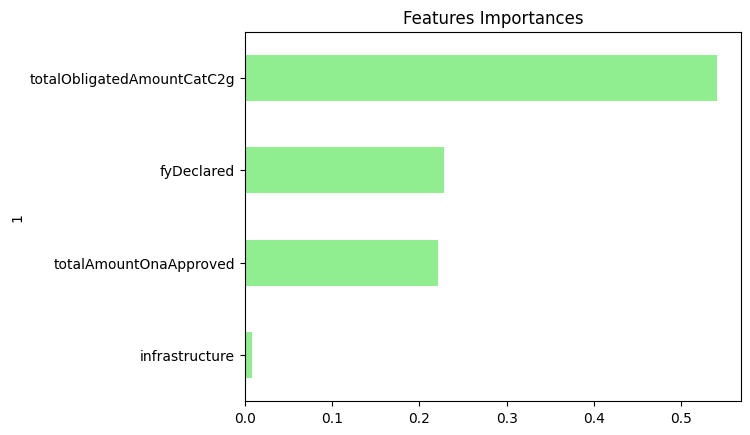

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
disaster_df.createOrReplaceTempView('disaster_all')

In [ ]:
spark.sql("""select avg(totalObligatedAmountCatC2g), incidentType
from disaster_all
group by incidentType
order by avg(totalObligatedAmountCatC2g) desc""").show()

+-------------------------------+-----------------+
|avg(totalObligatedAmountCatC2g)|     incidentType|
+-------------------------------+-----------------+
|            7.320148542628437E8|        Hurricane|
|           1.7383935699229178E8|       Earthquake|
|           1.2477601135309523E8|    Coastal_Storm|
|            5.219960172897247E7|            Flood|
|           5.0286105650000006E7|Volcanic_Eruption|
|           2.8911846180252407E7| Severe_Ice_Storm|
|            2.763007802595516E7|     Severe_Storm|
|           2.6178806285469882E7|             Fire|
|            2.498142837744186E7|          Typhoon|
|           2.3391834150882356E7|    Mud_Landslide|
|                 1.5692961235E7|  Dam_Levee_Break|
|                  1.270022092E7|          Tsunami|
|           1.2125513096991414E7|          Tornado|
|              7024930.763333333|            Other|
|              2888545.302744904|        Snowstorm|
|              2422796.087538462|     Winter_Storm|
|           

In [ ]:
spark.sql("""select avg(totalObligatedAmountCatC2g), incidentType
from disaster_all
group by incidentType
order by sum(totalObligatedAmountCatC2g) desc""").show()

+-------------------------------+-----------------+
|avg(totalObligatedAmountCatC2g)|     incidentType|
+-------------------------------+-----------------+
|            7.320148542628437E8|        Hurricane|
|            2.763007802595516E7|     Severe_Storm|
|            5.219960172897247E7|            Flood|
|           2.8911846180252407E7| Severe_Ice_Storm|
|           2.6178806285469882E7|             Fire|
|           1.7383935699229178E8|       Earthquake|
|           1.2477601135309523E8|    Coastal_Storm|
|           1.2125513096991414E7|          Tornado|
|              2888545.302744904|        Snowstorm|
|            2.498142837744186E7|          Typhoon|
|           2.3391834150882356E7|    Mud_Landslide|
|              2422796.087538462|     Winter_Storm|
|                  1.270022092E7|          Tsunami|
|           5.0286105650000006E7|Volcanic_Eruption|
|                 1.5692961235E7|  Dam_Levee_Break|
|              7024930.763333333|            Other|
|           